In [1]:
!pip install segmentation_models

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.8 MB/s eta 0:00:00


In [2]:
import os 
import keras
import numpy as np 
import pandas as pd
from tqdm import tqdm 
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data 
from glob import glob
import pathlib
import cv2 as cv
from tensorflow.image import resize
import tensorflow.image as tfi

# Model prepare
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from sklearn.model_selection import train_test_split

# Data visualization
import matplotlib.pyplot as plt

from PIL import Image

import subprocess
from IPython.display import FileLink, display

from keras.utils import  Sequence

import albumentations as A
import keras_tuner as kt

from functools import partial
AUTOTUNE = tf.data.experimental.AUTOTUNE


import scipy.ndimage as mp
from keras.preprocessing.image import img_to_array, load_img
from tensorflow.image import resize
import tensorflow.image as tfi

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [4]:
%env SM_FRAMEWORK=tf.keras
import segmentation_models as smp;

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


In [5]:
# создание ссылок на изображения и маски
images = sorted(glob(r'../input/aisegmentcom-matting-human-datasets/clip_img/*/*/*'))
masks = sorted(glob(r'../input/aisegmentcom-matting-human-datasets/matting/*/*/*'))

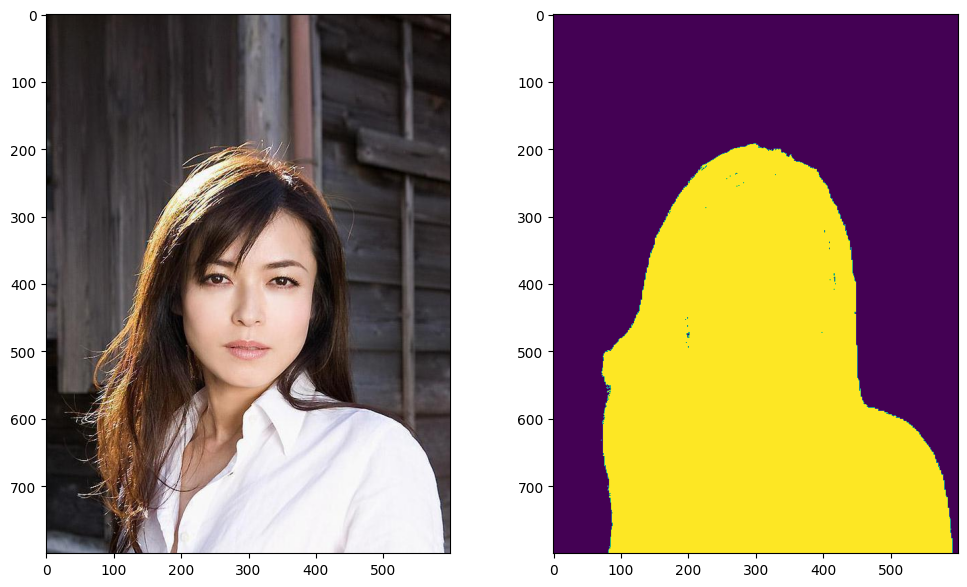

In [19]:
plt.figure(figsize=(12, 7))
plt.subplot(1,2,1)
im = plt.imread(images[99])
plt.imshow(im)
plt.subplot(1,2,2)
m = plt.imread(masks[99])
m  = (m[:,:,0]>0).astype(np.float32)
plt.imshow(m)
plt.show()

## Возьмем 20 % от исходного датасета

In [7]:
X ,X_, y, y_ = train_test_split(images, masks, test_size=0.80, random_state=44)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=44)

In [10]:
train = pd.DataFrame(list(zip(X_train,y_train)), columns =['X','y'])
test = pd.DataFrame(list(zip(X_test,y_test)), columns =['X','y'])

## Создание трансформера 

In [14]:
transform = A.Compose([
    A.ShiftScaleRotate(border_mode=cv.BORDER_CONSTANT, 
                          scale_limit=0.1,
                          rotate_limit=(10, 20),
                          p=0.5),
    A.HorizontalFlip(p=0.5), 
    A.RandomBrightnessContrast(p=0.4, brightness_limit=0.5, contrast_limit=0.5)])



transform_valid = A.Compose([])

In [21]:
def trancformers_show(img, mask, transform):
    plt.figure(figsize=(20,7))
    plt.subplot(1, 4, 1)
    image = cv.imread(img, cv.COLOR_BGR2RGB)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    plt.title("Исходное Изображение")
    plt.imshow(image)
        
    plt.subplot(1, 4, 2)
    plt.title("Маска")
    mask = cv.imread(mask)
    mask = (mask[:,:,0]>0).astype(np.float64) #mask = np.where(mask > 0, 1, mask)
    plt.imshow(mask)
        
    plt.subplot(1, 4, 3)
    plt.title("Трансформирование Изображение")
    train_gen = transform(image=image, mask=mask,)
    plt.imshow(train_gen['image'])
    
    plt.subplot(1, 4, 4)
    plt.title("Трансформирование Маска")
    plt.imshow(train_gen['mask']);

In [306]:
def make_shifts(img, mask):
    
    plt.figure(figsize=(12, 7))
    plt.subplot(1,2,1)
    im = plt.imread(img)
    plt.imshow(im)
    plt.subplot(1,2,2)
    
    m = plt.imread(mask)
    m = m[:,:,0]

    O = np.ones_like(m)
    Z = np.zeros_like(m)
    shift = 40
    
    
    R = np.roll(m, shift, axis=(0,1))   #- np.eye(m.shape[0], m.shape[1])
    R[:shift,:] = Z[:shift,:] # возвращаем падин с оригинала
    R[:,:shift] = Z[:,:shift]
    
    
    L = np.roll(m, -shift, axis=(0,1))   #- np.eye(m.shape[0], m.shape[1])
    L[-shift:,:] = Z[-shift:,:] # возвращаем падин с оригинала
    L[:,-shift:] = Z[:,-shift:]
    
    m = np.where(np.logical_or(np.logical_and(L>0,R>0), m>0), O,Z)
    
    plt.imshow(m)
    plt.show()

### Супер идея ТОПИЩЕ 

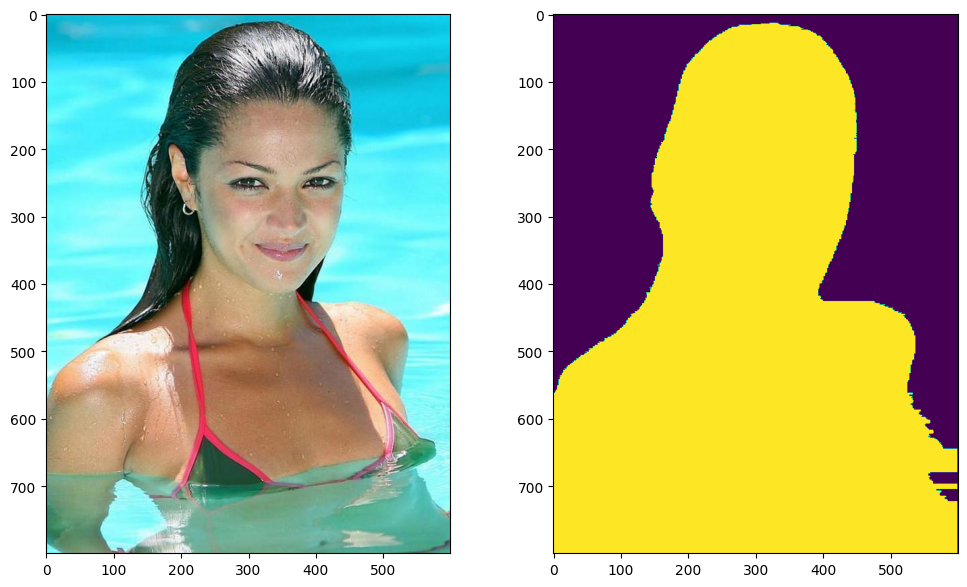

In [310]:
plt.figure(figsize=(12, 7))
plt.subplot(1,2,1)
im = plt.imread(images[7])
plt.imshow(im)
    
m = plt.imread(masks[7])
m = m[:,:,0]
m = (m[:,:]>0).astype(np.float16)

for i, vector in enumerate(m):
    Z = np.zeros_like(vector)
    O = np.ones_like(vector)
    one_indexs = []
    
    for i2, el in enumerate(vector):
        if el > 0:
            one_indexs.append(i2)
    if one_indexs:
        Z[one_indexs[0]:one_indexs[-1]] = O[one_indexs[0]:one_indexs[-1]]
        m[i,:] = Z
     
plt.subplot(1,2,2)  
plt.imshow(m);
   

            


In [ ]:
87 баг

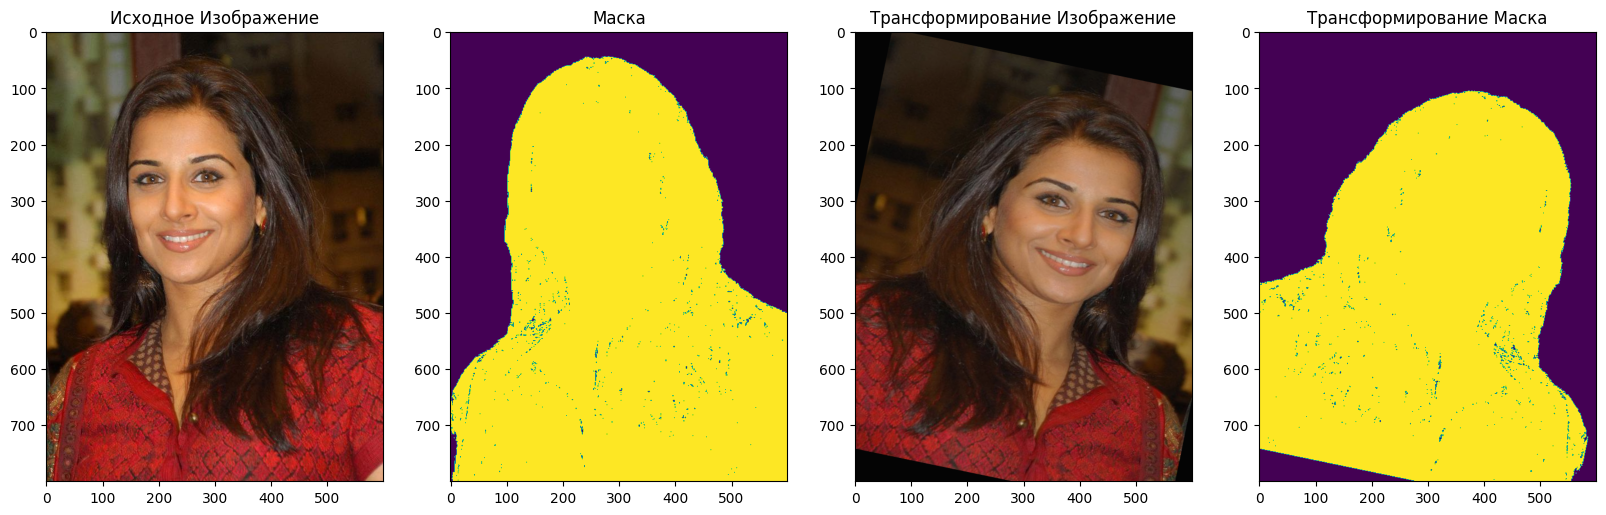

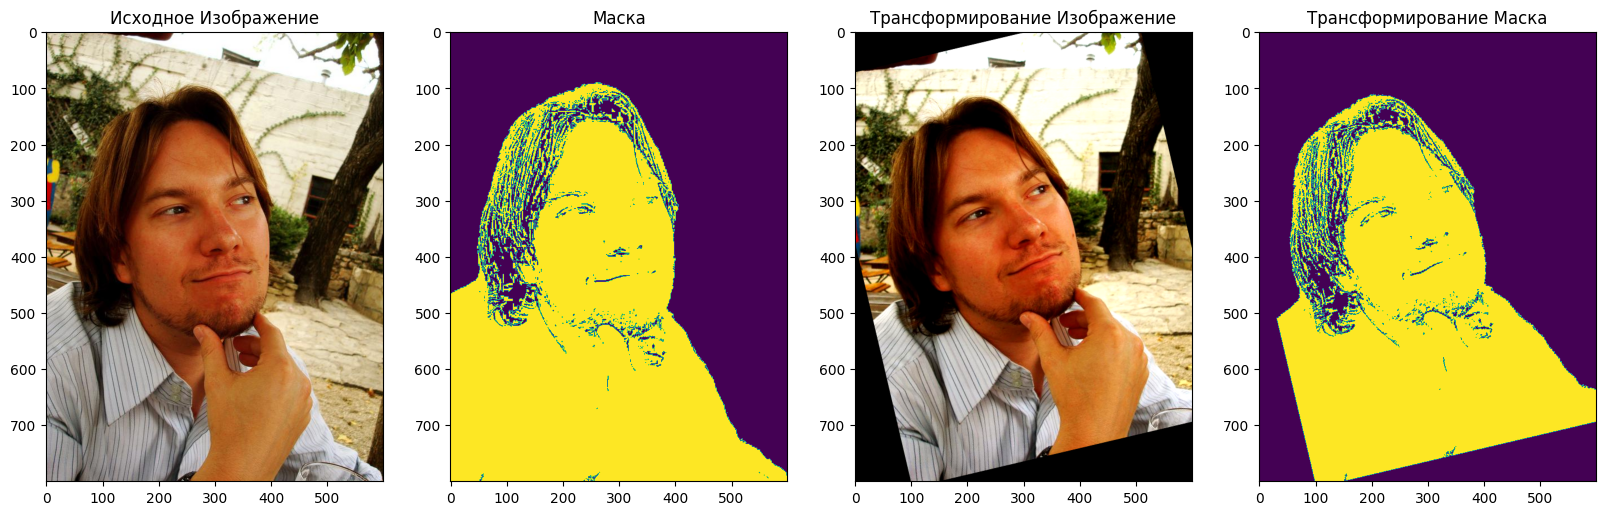

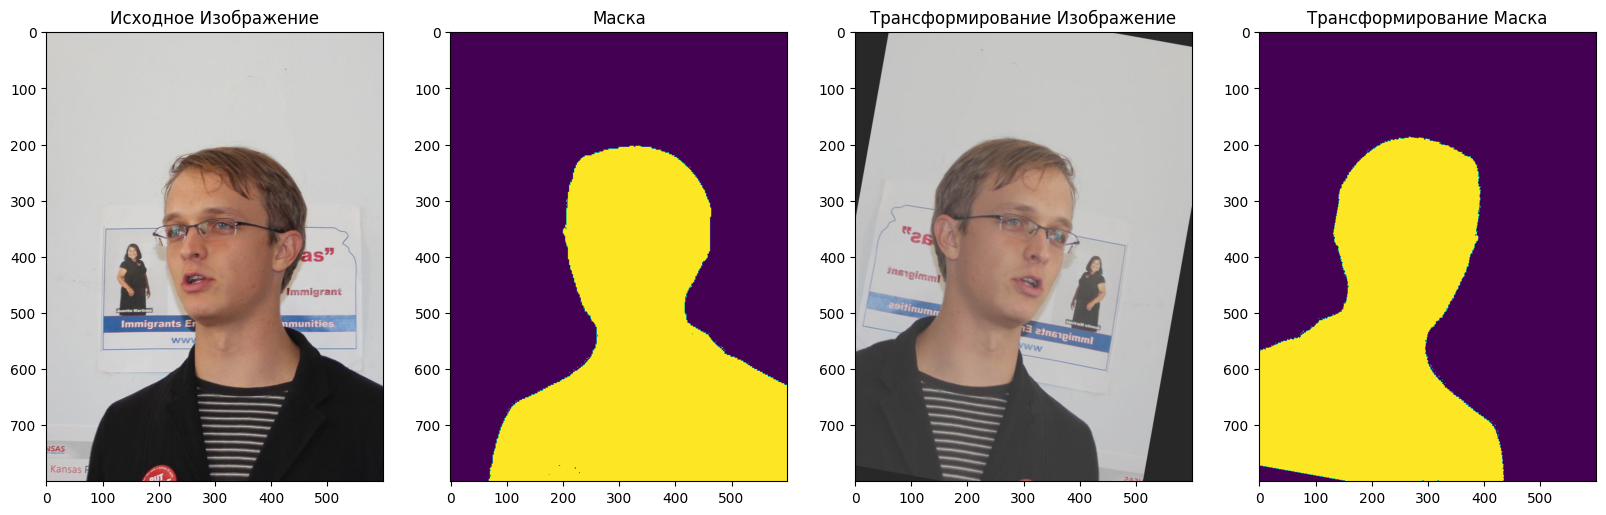

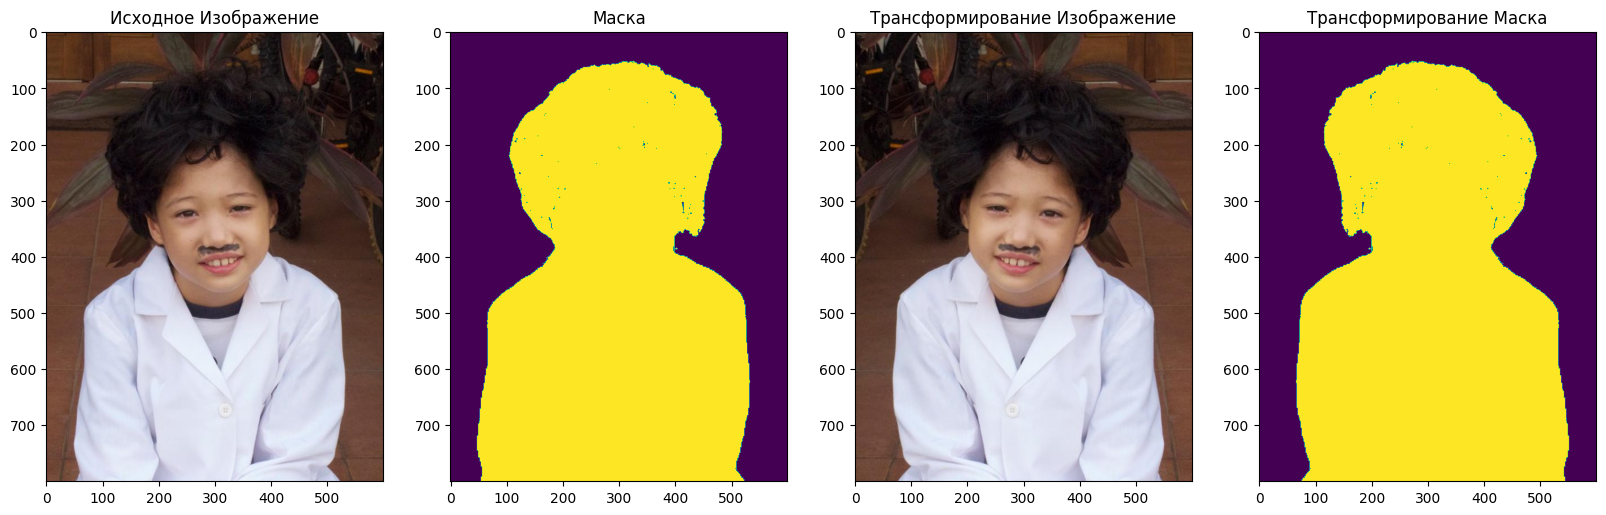

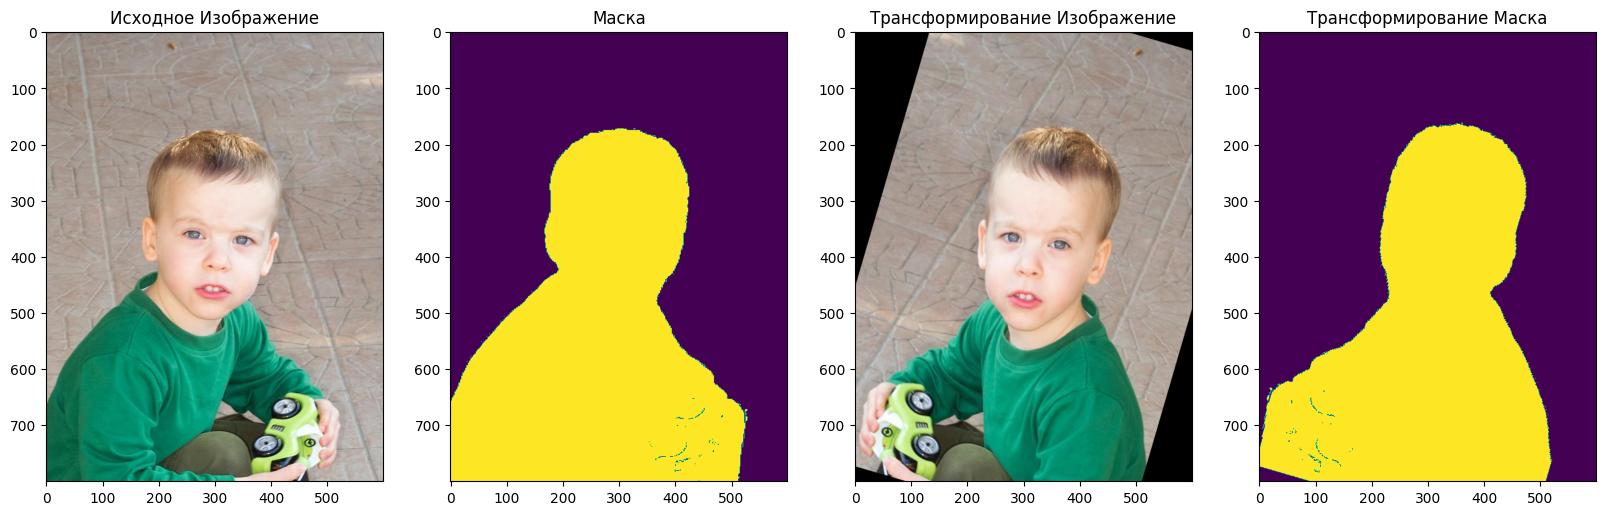

In [311]:
index = np.random.choice(range(len(images)), 5)
list_of_img = [images[i] for i in index]
list_of_mask =  [masks[i] for i in index]
for image, mask in zip(list_of_img, list_of_mask):
    trancformers_show(image, mask, transform)

## Проблема Matting 
Из за того что нам предоставлены matting изображения при создании маски стандартными методами часто наблюдаем в местах черного цвета отсутсвие маски из за чего модели будет намного сложнее обучится на данных так как ей придется запоминать дырки на изображение которые на самом деле являются частью изображения.
## Решение пролемы Matting
Сделаную маску из Matting разобьем на строки в строках выделем первое не нулевой и последней не нулевое значение. В созданом строке векторе заменим значения в прмежутке с первого не нулевого значения до последнего не нулевого значения на 1

In [313]:
def matting_solution(img, mask):
    # единственная проблема что не оч быстро раьотает
    # надо попробовать работать сразу со всей матрицей а не вектор строкой
    plt.figure(figsize=(12, 7))
    plt.subplot(1,2,1)
    im = plt.imread(img)
    plt.imshow(im)
        
    m = plt.imread(mask)
    m = m[:,:,0]
    m = (m[:,:]>0).astype(np.float16)
    
    for i, vector in enumerate(m):
        Z = np.zeros_like(vector)
        O = np.ones_like(vector)
        one_indexs = []
        
        for i2, el in enumerate(vector):
            if el > 0:
                one_indexs.append(i2)
        if one_indexs:
            Z[one_indexs[0]:one_indexs[-1]] = O[one_indexs[0]:one_indexs[-1]]
            m[i,:] = Z
         
    plt.subplot(1,2,2)  
    plt.imshow(m);
       

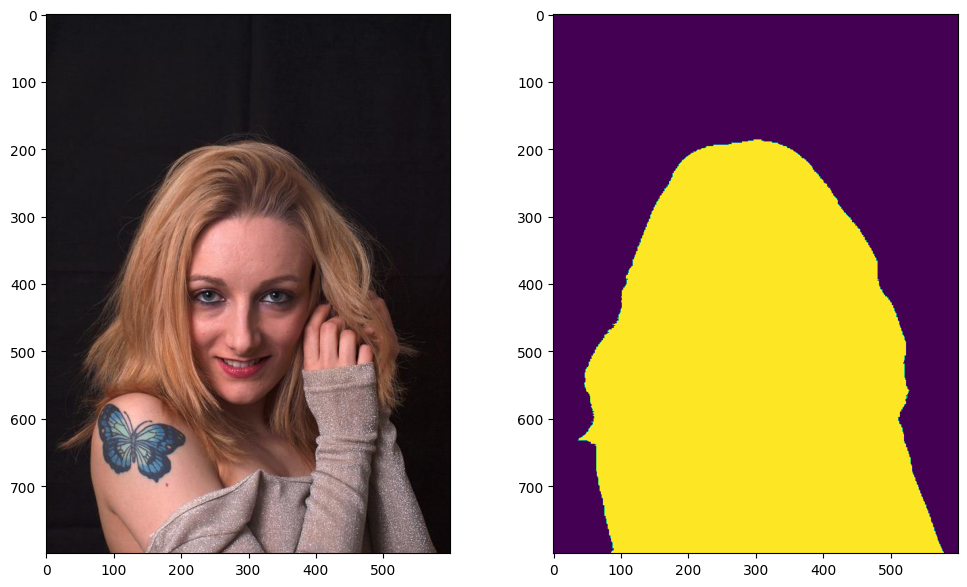

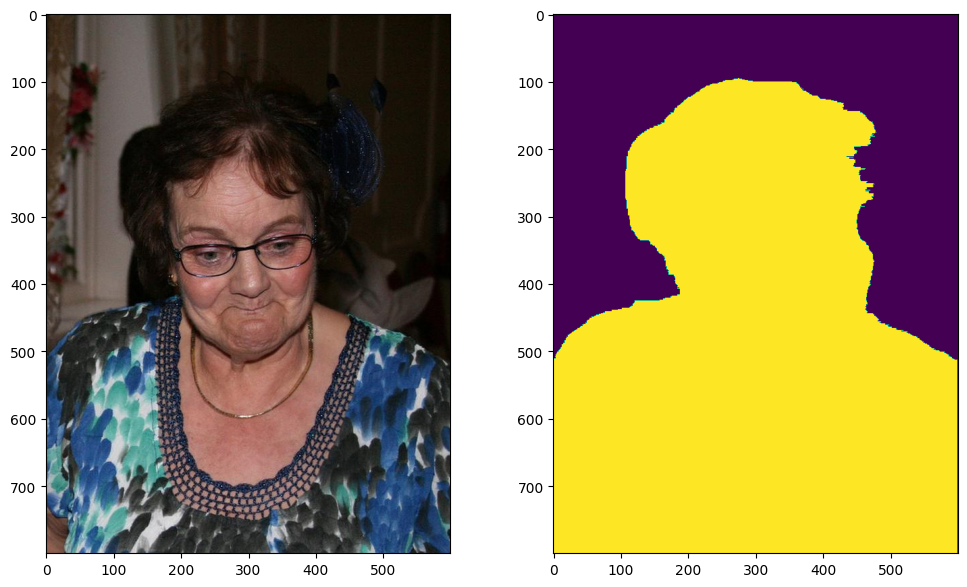

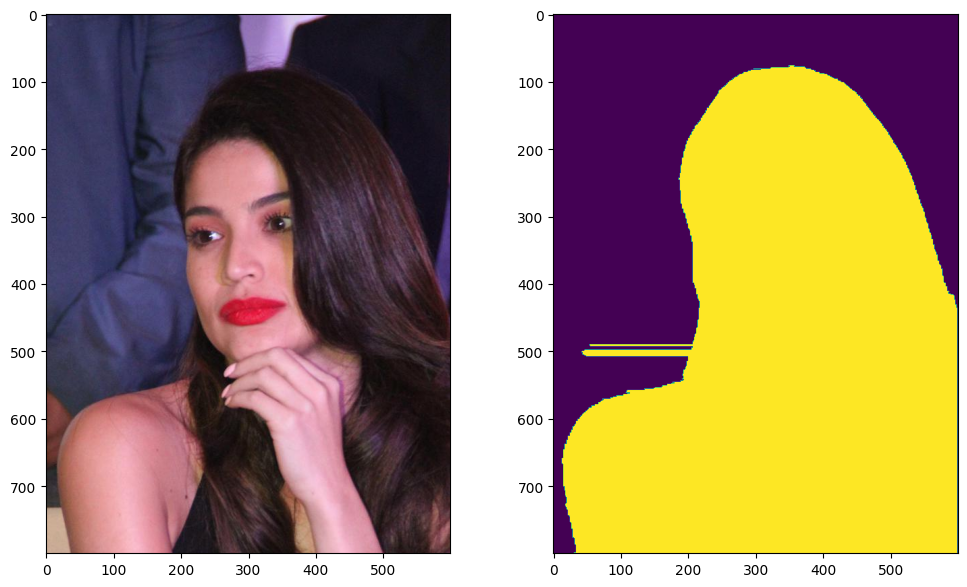

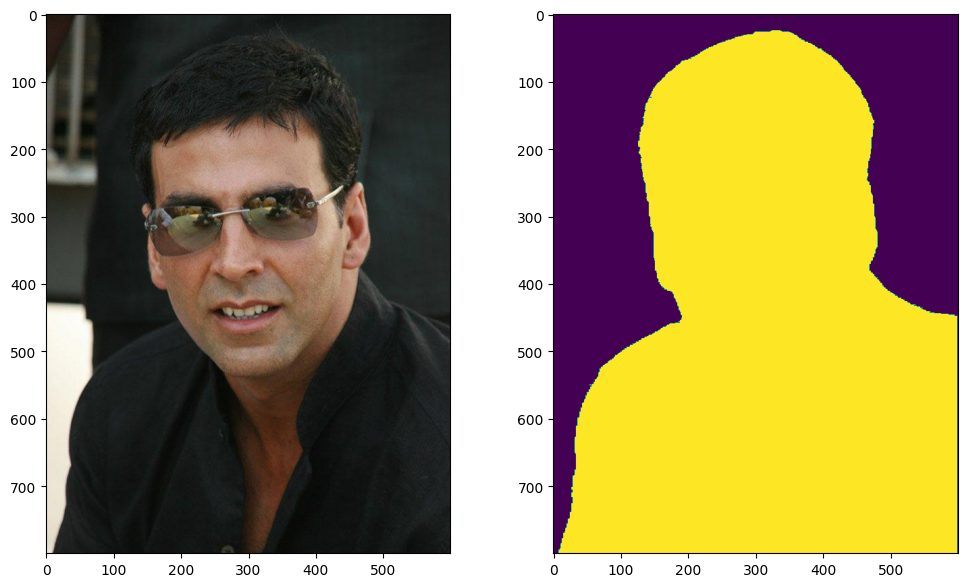

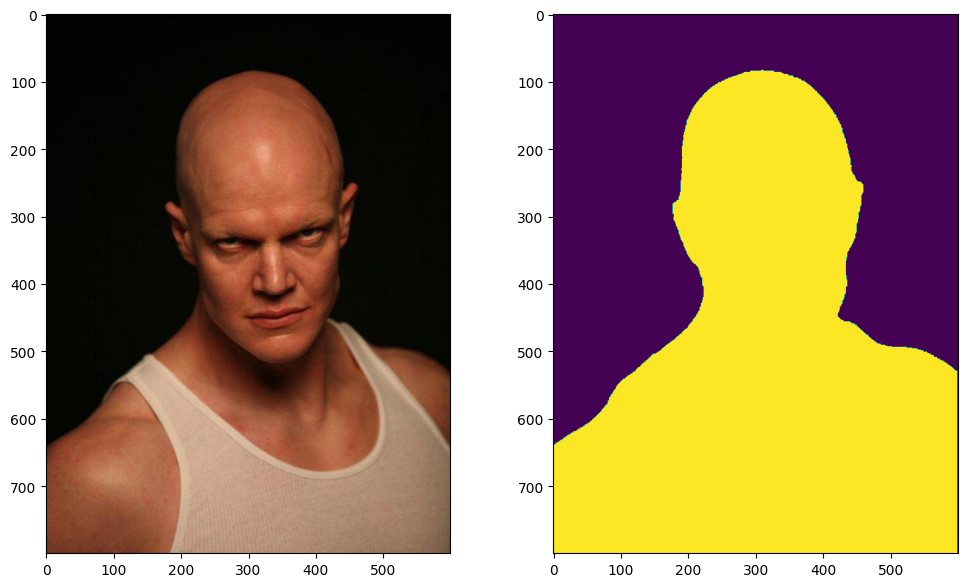

In [315]:
index = np.random.choice(range(len(images)), 5)
list_of_img = [images[i] for i in index]
list_of_mask =  [masks[i] for i in index]
for image, mask in zip(list_of_img, list_of_mask):
    matting_solution(image, mask)

## Создание Генератора с Трансформацией Изображений

In [317]:
class DataGenerator(Sequence):
    'Generates data for Keras'
    
    def __init__(self, images, labels, transformer, batch_size=32, workers=1, use_multiprocessing=False, max_queue_size=None, dim=(224,224,3), shuffle=True):
        
        super().__init__(workers, use_multiprocessing, max_queue_size)  #**kwargs)
        
        self.use_multiprocessing = use_multiprocessing
        self.workers = workers
        self.max_queue_size = max_queue_size
        
        self.dim = dim
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.transformer = transformer
        self.on_epoch_end() # 

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.images) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [k for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.images))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
            
    def _transform(self):
        transformer = transform(image=img, mask = label) 
        label = transformer['mask']
        img = transformer['img']
        img = tf.cast(img/255.0, tf.float32)
        label = tf.cast(label/255.0, tf.float32)
        img = tf.image.resize(img, size=[dim[0], dim[1]])
        label = tf.image.resize(label, size=[dim[0], dim[1]])
        return img, lable

    def _matting_solution(self,label):

    
        for i, vector in enumerate(label):
            Z = np.zeros_like(vector)
            O = np.ones_like(vector)
            one_indexs = []
        
            for i2, el in enumerate(vector):
                if el > 0:
                    one_indexs.append(i2)
            if one_indexs:
                Z[one_indexs[0]:one_indexs[-1]] = O[one_indexs[0]:one_indexs[-1]]
                label[i,:] = Z
            
        
        

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        batch_imgs = list()
        batch_labels = list()

        # Generate data
        for i in list_IDs_temp:
            # Store sample
            img = load_img(self.images[i] ,target_size=self.dim)
            img = img_to_array(img)/255.
            
            #Store class
            label = load_img(self.labels[i] ,target_size=self.dim)
            label = img_to_array(label)[:,:,0]
            label = label != 0


            label = _matting_solution(label)

            
            label = mp.binary_erosion(mp.binary_erosion(label))
            label = mp.binary_dilation(mp.binary_dilation(mp.binary_dilation(label)))
            label = np.expand_dims((label)*1 , axis=2)
            
            
            transformer = transform(image=img, mask = label) 
            label = transformer['mask']
            img = transformer['image']
            img = tf.cast(img/255.0, tf.float32)
            label = tf.cast(label/255.0, tf.float32)
            img = tf.image.resize(img, size=[self.dim[0], self.dim[1]])
            label = tf.image.resize(label, size=[self.dim[0], self.dim[1]])

            
            img = tf.numpy_function( inp=[img, self.dim[1]], Tout=tf.float32)
            label = tf.numpy_function( inp=[label, self.dim[1]], Tout=tf.float32)
            
            

            batch_imgs.append(img)
            batch_labels.append(label)
            
        return np.array(batch_imgs) ,np.array(batch_labels)

In [356]:
vector = tf.TensorArray.(1,2, 5)
#Z = tf.zeros_like(vector) 
vector.

In [348]:
class DataGenerator(Sequence):
    'Generates data for Keras'
    
    def __init__(self, images, labels, transformer=None, batch_size=32, workers=1, use_multiprocessing=False, max_queue_size=None, dim=(224,224,3), shuffle=True):
        
        super().__init__(workers, use_multiprocessing, max_queue_size)  #**kwargs)
        
        self.use_multiprocessing = use_multiprocessing
        self.workers = workers
        self.max_queue_size = max_queue_size
        
        self.dim = dim
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.transformer = transformer
        self.on_epoch_end() # 

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.images) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [k for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.images))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)


    def __matting_solution(self, label):

        for i, vector in enumerate(label):
            Z = tf.zeros_like(vector) 
            O = tf.ones_like(vector)
            one_indexs = []
        
            for i2, el in enumerate(vector):
                if el > 0:
                    one_indexs.append(i2)
            if one_indexs:
                Z[one_indexs[0]:one_indexs[-1]] = O[one_indexs[0]:one_indexs[-1]]
                label[i,:] = Z
            
            
    def __transform(self, img, label):
        transformer = self.transformer(image=img, mask = label) 
        label = transformer['mask']
        img = transformer['image']
        img = tf.cast(img/255.0, tf.float32)
        label = tf.cast(label/255.0, tf.float32)
        img = tf.image.resize(img, size=[self.dim[0], self.dim[1]])
        label = tf.image.resize(label, size=[self.dim[0], self.dim[1]])

        return img, label
        

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        batch_imgs = list()
        batch_labels = list()

        # Generate data
        for i in list_IDs_temp:
            # Store sample
            img = load_img(self.images[i] ,target_size=self.dim)
            img = img_to_array(img)/255.
            
            #Store class
            label = load_img(self.labels[i] ,target_size=self.dim)
            label = img_to_array(label)[:,:,0]
            label = label != 0

            label = self.__matting_solution(label)
            
            label = mp.binary_erosion(mp.binary_erosion(label))
            label = mp.binary_dilation(mp.binary_dilation(mp.binary_dilation(label)))
            label = np.expand_dims((label)*1 , axis=2)

            

            
            
            if self.transformer != None:
                #transformer = _transform(image=img, mask = label) 
                img, label = tf.numpy_function(func=self.__transform,  inp=[img, label], Tout=tf.float32)#, inp=[img, self.dim[1]], Tout=tf.float32)
                #label = tf.numpy_function(func=self.__transform, inp=[label], Tout=tf.float32)#, inp=[label, self.dim[1]], Tout=tf.float32)
            
            

            batch_imgs.append(img)
            batch_labels.append(label)
            
        return np.array(batch_imgs) ,np.array(batch_labels)

In [349]:
generator = DataGenerator(X_train, y_train,  transformer=transform, batch_size=32, dim=(224,224,3),shuffle=True)
validator = DataGenerator( X_test, y_test, transformer=transform, batch_size=32, dim=(224,224,3))

In [325]:
BACKBONE = 'efficientnetb0'
segmodel = smp.FPN(backbone_name = BACKBONE, classes=1, activation='relu',encoder_weights ='imagenet')

In [ ]:
def build_model(hp, num_classes=9, shape=(256,256,3)):
    inputs = tf.keras.layers.Input(shape=shape)
    model = EfficientNetB0(include_top=False,
        weights='imagenet',
        input_tensor=inputs, # !
        input_shape=None,
        pooling=None,
        #classes=num_classes,
        classifier_activation='softmax')
    
    model.trainable = False

    # Rebuild top
    x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = tf.keras.layers.BatchNormalization()(x)
    top_dropout_rate = 0.2
    x = tf.keras.layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = keras.Model(inputs, outputs, name="EfficientNetB0")
    
    loss = tf.keras.losses.Tversky(alpha=0.4,beta=0.9)
    optimizer = keras.optimizers.Nadam(
    learning_rate=0.0001,
    beta_1=0.7,
    beta_2=0.999,
    epsilon=1e-07,
    use_ema=True,
    ema_momentum=0.89,
    
            ) 
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    hp_optimizer = hp.Choice('optimizer', values=['sgd', 'rmsprop', 'adam','nadam'])
    if hp_optimizer == 'sgd':
        optimizer = keras.optimizers.SGD(learning_rate=hp_learning_rate)
    elif hp_optimizer == 'rmsprop':
        optimizer = keras.optimizers.RMSprop(learning_rate=hp_learning_rate)
    elif hp_optimizer == 'adam':
        optimizer = keras.optimizers.Adam(learning_rate=hp_learning_rate)
    elif hp_optimizer == 'nadam':
        optimizer = keras.optimizers.Nadam(learning_rate=hp_learning_rate)
    else:
        raise
    
    model.compile(loss=loss, metrics=['accuracy'], optimizer=optimizer)
    
    
    return model

In [350]:
optimizer = keras.optimizers.Nadam(
    learning_rate=0.0001,
    beta_1=0.7,
    beta_2=0.999,
    epsilon=1e-07,
    use_ema=True,
    ema_momentum=0.89,
    
)


loss = tf.keras.losses.Dice(
    reduction='sum_over_batch_size', name='dice'
)  #tf.keras.losses.Tversky(alpha=0.4,beta=0.9) # нам важно само изображение а не фон
segmodel.compile(optimizer= optimizer, loss=loss, metrics = [tf.keras.metrics.BinaryIoU(target_class_ids=[1], name="IoU"), 'accuracy'])
segmodel.fit(generator, epochs=2, batch_size=16)

TypeError: 'tensorflow.python.framework.ops.EagerTensor' object does not support item assignment

In [ ]:
### rkfc c альбум

class AAugmentationTf:
    
    def __init__(self, transform, image_size, batch_size=30):
        '''
        PARAMETERS
        ----------
        
        transform   : Albumentations augmentation pipeline of type
                      'albumentations.core.composition.Compose'
                   
        image_size  : size of the target image or after augmentation
        
        batch_size  : Batch size of the output tf dataset defaults to
        (default=30)  to 30.

        '''
        self.transform = transform
        self.image_size = image_size
        self.batch_size = batch_size


    def augment(self, ds):
        '''
        PARAMETERS
        ----------
        ds: Tensorflow Dataset 'tf.data.Dataset' with
            image & labels (mandatory)
        
        RETURNS
        -------
        ds_trans: Returns a tf dataset with augmentation 
                  pipeline applied.
        '''
        
        AUTOTUNE = tf.data.experimental.AUTOTUNE
        ds_trans = ds.map(partial(self._process_data), num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
        ds_trans = ds_trans.map(self._set_shapes, num_parallel_calls=AUTOTUNE).\
        batch(self.batch_size).prefetch(AUTOTUNE)
        return ds_trans

        
    def _augment_func(self, image):
        transformed = self.transform(image=image, mask=mask)
        transformed_image = transformed_image['image']
        transformed_mask = transformed_image['mask']
        transformed_image = tf.cast(transformed_image/255., tf.float32)
        return transformed_image

    
    def _process_data(self, image, mask):
        transformed_image = tf.numpy_function(self._augment_func, inp=[image], Tout=tf.float32)
        transformed_mask = tf.numpy_function(self._augment_func, inp=[image], Tout=tf.float32)
        return transformed_image, transformed_mask

    
    def _set_shapes(self, img, mask):
        img.set_shape(self.image_size)
        label.set_shape([])
        return img, label

### Еще один класс

In [ ]:
class AugmentDataGenerator(Sequence):
    def __init__(self, datagen, augment=None):
        self.datagen = datagen
        if augment is None:
            self.augment = A.Compose([])
        else:
            self.augment = augment

    def __len__(self):
        return len(self.datagen)

    def __getitem__(self, x):
        images, *rest = self.datagen[x]
        augmented = []
        for image in images:
            image = self.augment(image=image)['image']
            augmented.append(image)
        return (np.array(augmented), *rest)


datagen = ImageDataGenerator()\
    .flow_from_dataframe(
            train, x_col='X', y_col="y",
    )

datagen = AugmentDataGenerator(datagen, A.Compose([
    A.RandomResizedCrop(256, 256),
    A.Flip(),
    A.Rotate(),
]))


optimizer = keras.optimizers.Nadam(
    learning_rate=0.0001,
    beta_1=0.7,
    beta_2=0.999,
    epsilon=1e-07,
    use_ema=True,
    ema_momentum=0.89,
)

loss = tf.keras.losses.Tversky(alpha=0.4,beta=0.9) # нам важно само изображение а не фон
segmodel.compile(optimizer= optimizer, loss=loss, metrics = [tf.keras.metrics.BinaryIoU(target_class_ids=[1], name="IoU"), 'accuracy'])
segmodel.fit(datagen, epochs=1, batch_size=16)

# Только изображение

In [53]:
def aug(image):
    image = plt.imread(image)
    transform = A.Compose([
        A.Flip(),
        A.Rotate(),
    ])
    a = transform(image=image)
    return a['image']


optimizer = keras.optimizers.Nadam(
    learning_rate=0.0001,
    beta_1=0.7,
    beta_2=0.999,
    epsilon=1e-07,
    use_ema=True,
    ema_momentum=0.89,
)

datagen = ImageDataGenerator(preprocessing_function=aug)
datagen_valid = ImageDataGenerator()
train_gen = datagen.flow_from_dataframe(train, x_col='X', y_col="y",)
test_gen = datagen_valid.flow_from_dataframe(test, x_col='X', y_col="y",)


loss = tf.keras.losses.Tversky(alpha=0.4,beta=0.9) # нам важно само изображение а не фон
segmodel.compile(optimizer= optimizer, loss=loss, metrics = [tf.keras.metrics.BinaryIoU(target_class_ids=[1], name="IoU"), 'accuracy'])
segmodel.fit(train_gen, validation_data=test_gen, epochs=1, batch_size=16)

# Изображение и маска

In [44]:
def aug_fn(image, mask, img_size):
    data = {"image":image,"mask":mask}
    transforms = A.Compose([
    A.ShiftScaleRotate(border_mode=cv.BORDER_CONSTANT, 
                          scale_limit=0.1,
                          rotate_limit=(10, 20),
                          p=0.5),
    A.HorizontalFlip(p=0.5), 
    A.RandomBrightnessContrast(p=0.4, brightness_limit=0.5, contrast_limit=0.5)])
    
    mask = plt.imread(mask)

    image = plt.imread(image)
    aug_data = transforms(**data)
    aug_img = aug_data["image"]
    aug_mask = aug_data["mask"]
    aug_img = tf.cast(aug_img/255.0, tf.float32)
    aug_mask = tf.cast(aug_img/255.0, tf.float32)
    return tf.image.resize(aug_img, size=[img_size, img_size]), tf.image.resize(aug_mask, size=[img_size, img_size])


def process_data(image, mask, img_size):
    aug_img = tf.numpy_function(func=aug_fn, inp=[image, img_size], Tout=tf.float32)
    return aug_img, mask

#ds_alb = data.map(partial(process_data, img_size=120),
#                  num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
#ds_alb


optimizer = keras.optimizers.Nadam(
    learning_rate=0.0001,
    beta_1=0.7,
    beta_2=0.999,
    epsilon=1e-07,
    use_ema=True,
    ema_momentum=0.89,
)

datagen = ImageDataGenerator(preprocessing_function=aug)
datagen_valid = ImageDataGenerator()
train_gen = datagen.flow_from_dataframe(train, x_col='X', y_col="y",)
test_gen = datagen_valid.flow_from_dataframe(test, x_col='X', y_col="y",)


loss = tf.keras.losses.Tversky(alpha=0.4,beta=0.9) # нам важно само изображение а не фон
segmodel.compile(optimizer= optimizer, loss=loss, metrics = [tf.keras.metrics.BinaryIoU(target_class_ids=[1], name="IoU"), 'accuracy'])
segmodel.fit(train_gen, validation_data=test_gen, epochs=1, batch_size=16)

## через лямбду и ицикл 

In [54]:
datagen = ImageDataGenerator(preprocessing_function=aug)
datagen_valid = ImageDataGenerator()

In [51]:
datagen.apply_transform(ImageDataGenerator)

AttributeError: 'ImageDataGenerator' object has no attribute 'augment'

In [55]:
train_gen = datagen.flow_from_dataframe(train, x_col='X', y_col="y",)
test_gen = datagen_valid.flow_from_dataframe(test, x_col='X', y_col="y",)

Found 5508 validated image filenames belonging to 5508 classes.
Found 1377 validated image filenames belonging to 1377 classes.


In [ ]:
def aug_fn(image, mask, img_size):
    data = {"image":image,"mask":mask}
    aug_data = transforms(**data)
    aug_img = aug_data["image"]
    aug_mask = aug_data["mask"]
    aug_img = tf.cast(aug_img/255.0, tf.float32)
    aug_mask = tf.cast(aug_img/255.0, tf.float32)
    return tf.image.resize(aug_img, size=[img_size, img_size]), tf.image.resize(aug_mask, size=[img_size, img_size])


def process_data(image, mask, img_size):
    aug_img = tf.numpy_function(func=aug_fn, inp=[image, img_size], Tout=tf.float32)
    return aug_img, mask

ds_alb = data.map(partial(process_data, img_size=120),
                  num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
ds_alb

In [ ]:
tf.data.Dataset.

In [17]:
BACKBONE = 'efficientnetb0'
segmodel = smp.FPN(backbone_name = BACKBONE, classes=1, activation='relu',encoder_weights ='imagenet', encoder_freeze=True,pyramid_use_batchnorm=True,pyramid_dropout=0.25)
segmodel.fit(train_gen, validation_data=test_gen, epochs=1, batch_size=16)

16804768/16804768 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [18]:
optimizer = keras.optimizers.Nadam(
    learning_rate=0.0001,
    beta_1=0.7,
    beta_2=0.999,
    epsilon=1e-07,
    use_ema=True,
    ema_momentum=0.89,
)

loss = tf.keras.losses.Tversky(alpha=0.4,beta=0.9) # нам важно само изображение а не фон
segmodel.compile(optimizer= optimizer, loss=loss, metrics = [tf.keras.metrics.BinaryIoU(target_class_ids=[1], name="IoU"), 'accuracy'])
segmodel.fit(train_gen, validation_data=test_gen, epochs=1, batch_size=16)

In [56]:
segmodel.fit(train_gen, validation_data=test_gen, epochs=1, batch_size=16)

/tmp/ipykernel_30/1205960487.py:3: DeprecationWarning: Flip is deprecated. Consider using HorizontalFlip, VerticalFlip, RandomRotate90 or D4.
  A.Flip(),


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
def aug_fn(image, img_size):
    data = {"image":image}
    aug_data = transforms(**data)
    aug_img = aug_data["image"]
    aug_img = tf.cast(aug_img/255.0, tf.float32)
    return tf.image.resize(aug_img, size=[img_size, img_size])

def aug_fn(image, img_size):
    data = {"image":image}
    aug_data = transforms(**data)
    aug_img = aug_data["image"]
    aug_img = tf.cast(aug_img/255.0, tf.float32)
    return tf.image.resize(aug_img, size=[img_size, img_size])

def set_shapes(img, label, img_shape=(120,120,3)):
    img.set_shape(img_shape)
    label.set_shape([])
    return img, label


In [ ]:
transform.

In [ ]:
train = keras.utils.fro

In [ ]:
aug_images = images.map(partial(process_data, img_size=[416, 312]), num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)


In [ ]:
ds_alb = data.map(partial(process_data, img_size=120),
                  num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
ds_alb

In [ ]:
train_gen = transforms(image=train['X'], mask=train['y'])

image_transformed = transformed['image']
mask_transformed = transformed['mask']

In [ ]:
datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.15,
        height_shift_range=0.15,
        shear_range=0.2,
        zoom_range=0.2,

        brightness_range=(1.0, 0.8))
datagen_valid = ImageDataGenerator()

## Обучение

In [ ]:
def build_model(hp, shape=(256,256,3)):
    inputs = tf.keras.layers.Input(shape=shape)
    model = EfficientNetB0(include_top=False,
        weights='imagenet',
        input_tensor=inputs, # !
        input_shape=None,
        pooling=None,
        #classes=num_classes,
        classifier_activation='softmax')
    
    model.trainable = False

    # Rebuild top
    x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = tf.keras.layers.BatchNormalization()(x)
    top_dropout_rate = 0.2
    x = tf.keras.layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    #outputs = tf.keras.layers.Dense(, activation="softmax", name="pred")(x)

    # Compile
    model = keras.Model(inputs, outputs, name="EfficientNetB0")
    
    loss = tf.keras.losses.CategoricalFocalCrossentropy(
        alpha=0.25,
        gamma=2.0,
        from_logits=False)
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    hp_optimizer = hp.Choice('optimizer', values=['sgd', 'rmsprop', 'adam','nadam'])
    if hp_optimizer == 'sgd':
        optimizer = keras.optimizers.SGD(learning_rate=hp_learning_rate)
    elif hp_optimizer == 'rmsprop':
        optimizer = keras.optimizers.RMSprop(learning_rate=hp_learning_rate)
    elif hp_optimizer == 'adam':
        optimizer = keras.optimizers.Adam(learning_rate=hp_learning_rate)
    elif hp_optimizer == 'nadam':
        optimizer = keras.optimizers.Nadam(learning_rate=hp_learning_rate)
    else:
        raise
    
    model.compile(loss=loss, metrics=['accuracy'], optimizer=optimizer)
    
    
    return model

In [ ]:
callback = [EarlyStopping(
    monitor='IoU', #
    min_delta=0,
    patience=0,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=30
), ShowProgress(valid)]
# рання остановка при равенстве валидационного лоса лосу тренировочных данных

In [ ]:
BACKBONE = 'efficientnetb0'
segmodel = smp.FPN(backbone_name = BACKBONE, classes=1, activation='relu',encoder_weights ='imagenet')

In [ ]:
optimizer = 

In [ ]:
optimizer = keras.optimizers.Nadam(
    learning_rate=0.0001,
    beta_1=0.7,
    beta_2=0.999,
    epsilon=1e-07,
    use_ema=True,
    ema_momentum=0.89,
)

In [ ]:
segmodel.compile(optimizer= optimizer, loss="binary_crossentropy", metrics = [tf.keras.metrics.BinaryIoU(target_class_ids=[1], name="IoU"), 'accuracy'])
epochs = 40
hist = segmodel.fit(generator, epochs=epochs, batch_size=32, callbacks=[callback], validation_data=valid)

## Провекрка метрик на валидационой и тестовой выборке

In [ ]:
res_val = segmodel.evaluate(valid)

In [ ]:
res_test = segmodel.evaluate(generator)